In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2025-06-09 19:25:58.691807: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 19:25:58.696310: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 19:25:58.707892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749489958.726213   91989 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749489958.731467   91989 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749489958.746842   91989 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Loading Dataset

Considering only more than 3 sec files and
labelling the files as Normal or Abnormal

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [2]:
dataset = []
for folder in ["./set_a/**","./set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        if (label == "normal"):
                            dataset.append({
                                "filename": filename,
                                "label": "normal",
                                "offset": offset
                            })
                        else:
                            dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                "offset": offset
                            })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1281 entries, 1241 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1281 non-null   object 
 1   label     1281 non-null   object 
 2   offset    1281 non-null   float64
dtypes: float64(1), object(2)
memory usage: 40.0+ KB


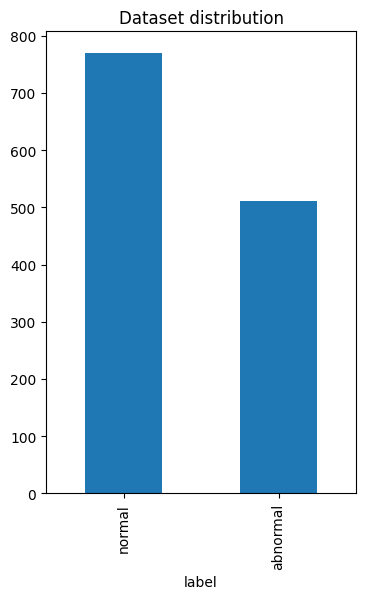

In [3]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [4]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1024
Test: 257


## Visualising the data and features

./set_b/normal__179_1307990076841_B.wav
./set_b/murmur__197_1308141235553_D.wav


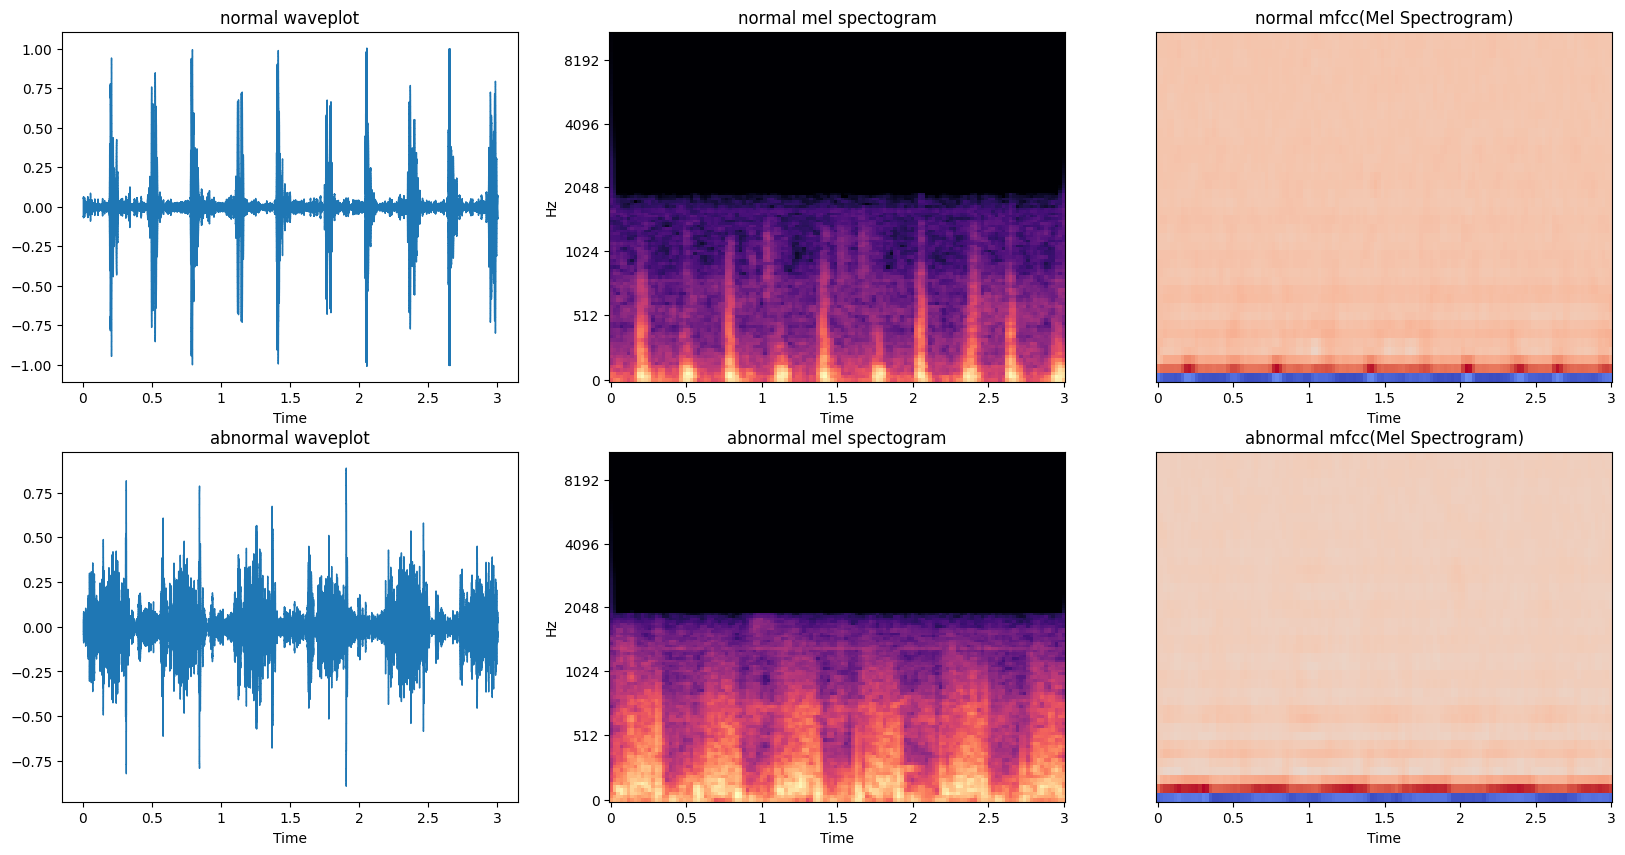

In [7]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    # Wave plot
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveshow(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
plt.show()

## Extracting features

In [10]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [11]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|████████████████████████████████████████| 257/257 [00:02<00:00, 124.01it/s]

X train: (1024, 40, 130)
X test: (257, 40, 130)


In [13]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

## Input Shapes

In [14]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1024, 40, 130, 1)
Y train: (1024, 2)
X test: (257, 40, 130, 1)
Y test: (257, 2)


## Building Model

In [16]:
# model = Sequential()
# model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))

# model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))

# model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))

# model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.5))
# model.add(GlobalAveragePooling2D())

# model.add(Dense(len(encoder.classes_), activation='softmax'))
# model.summary()

model = Sequential()

# Use the explicit and CORRECT 4D input shape.
# Shape is (height, width, channels) or (timesteps, features, channels)
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(130, 40, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())

# Your final layer for multi-class classification is correct
# Assuming 'encoder' is your LabelEncoder
model.add(Dense(len(encoder.classes_), activation='softmax'))

model.summary()

/home/ggwp/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1749490888.402792   91989 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1749490888.405402   91989 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 129, 39, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 18, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 8, 64)      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 3, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,570 (170.20 KB)

 Trainable params: 43,570 (170.20 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling Model

In [17]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Fitting Model

In [19]:
%%time
# Convert to dictionary format
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              class_weight=class_weights_dict,
              shuffle=True)

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4648 - loss: 7.9356 - val_accuracy: 0.5253 - val_loss: 0.9223
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4788 - loss: 3.5636 - val_accuracy: 0.6226 - val_loss: 0.7834
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5888 - loss: 2.3931 - val_accuracy: 0.4436 - val_loss: 1.0727
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5147 - loss: 1.8703 - val_accuracy: 0.4514 - val_loss: 0.8499
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5484 - loss: 1.2752 - val_accuracy: 0.4903 - val_loss: 0.6870
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6112 - loss: 1.1824 - val_accuracy: 0.4591 - val_loss: 0.7234
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5367 - loss: 1.0299 - val_accuracy: 0.6615 - val_loss: 0.6351
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5975 - loss: 0.8551 - val_accuracy: 0.7121 - val_loss:

Epoch 223/300
1024/1024 [==============================] - 2s 2ms/step - loss: 0.3387 - accuracy: 0.8438 - val_loss: 0.4194 - val_accuracy: 0.7938
Epoch 224/300
1024/1024 [==============================] - 2s 2ms/step - loss: 0.3275 - accuracy: 0.8633 - val_loss: 0.4209 - val_accuracy: 0.7821
Epoch 225/300
1024/1024 [==============================] - 2s 2ms/step - loss: 0.3132 - accuracy: 0.8623 - val_loss: 0.4273 - val_accuracy: 0.7782
Epoch 226/300
1024/1024 [==============================] - 2s 2ms/step - loss: 0.3339 - accuracy: 0.8525 - val_loss: 0.4149 - val_accuracy: 0.7938
Epoch 227/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.3336 - accuracy: 0.8340 - val_loss: 0.4147 - val_accuracy: 0.7860
Epoch 228/300
1024/1024 [==============================] - 2s 1ms/step - loss: 0.3373 - accuracy: 0.8516 - val_loss: 0.4117 - val_accuracy: 0.7860
Epoch 229/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.3158 - accuracy: 0.8555 - val_loss: 0

Epoch 279/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2624 - accuracy: 0.8857 - val_loss: 0.3703 - val_accuracy: 0.8249
Epoch 280/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2574 - accuracy: 0.8857 - val_loss: 0.3716 - val_accuracy: 0.8288
Epoch 281/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2693 - accuracy: 0.8799 - val_loss: 0.3761 - val_accuracy: 0.8210
Epoch 282/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2559 - accuracy: 0.8809 - val_loss: 0.3663 - val_accuracy: 0.8171
Epoch 283/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2824 - accuracy: 0.8721 - val_loss: 0.3952 - val_accuracy: 0.7860
Epoch 284/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2694 - accuracy: 0.8779 - val_loss: 0.3582 - val_accuracy: 0.8327
Epoch 285/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2768 - accuracy: 0.8789 - val_loss: 0

## Evaluating model

Text(0.5, 1.0, 'Accuracy Curves')

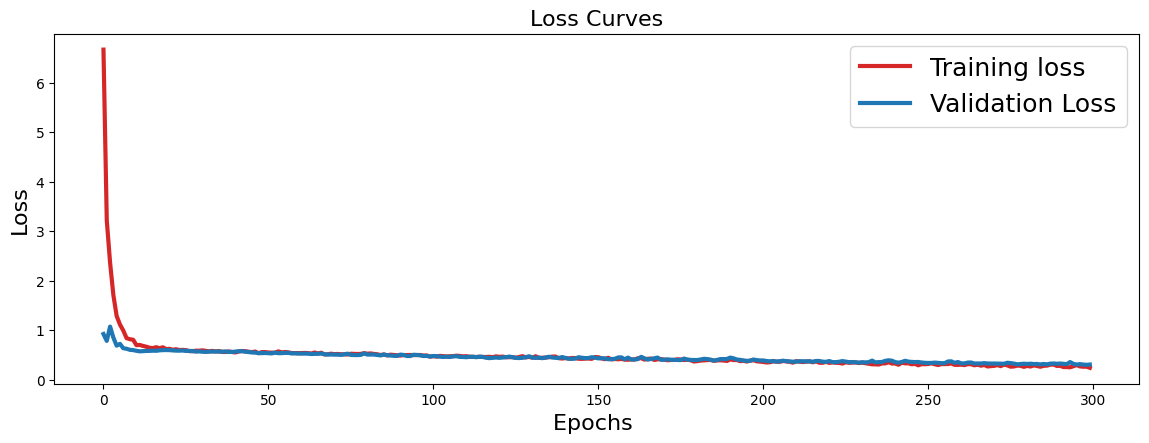

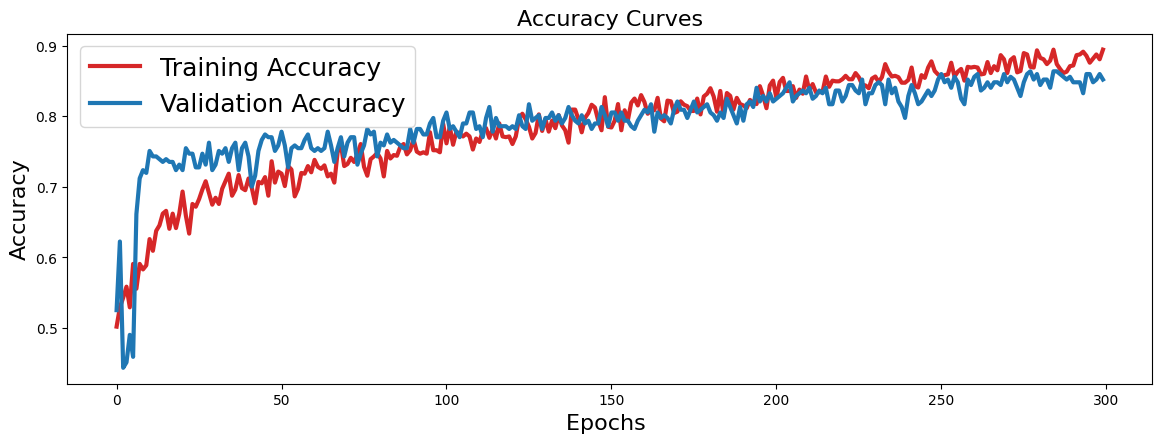

In [20]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [21]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8436 - loss: 0.3272 
Test loss: 0.30613160133361816
Test accuracy: 0.8521400690078735


In [22]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

    abnormal       0.79      0.87      0.83       104
      normal       0.90      0.84      0.87       153

    accuracy                           0.85       257
   macro avg       0.85      0.85      0.85       257
weighted avg       0.86      0.85      0.85       257



### Save Model and Weights

In [23]:
model_name = "heartbeat_classifier (normalised).h5"
model.save(model_name)

In [ ]:
# 1 sec overlap
# Trained for 3sec for files >3sec

### Classifying an heart beat

In [ ]:
# # load and evaluate a saved model
# from keras.models import load_model
 
# # load model
# model = load_model("trained_heartbeat_classifier.h5")

# # File to be classified
# classify_file = "my_heartbeat.wav"
# x_test = []
# x_test.append(extract_features(classify_file,0.5))
# x_test = np.asarray(x_test)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
# pred = model.predict(x_test,verbose=1)

# print(pred)

In [ ]:
# pred_class = model.predict_classes(x_test)
# if pred_class[0]:
#     print("Normal heartbeat")
#     print("confidence:",pred[0][1])
# else:
#     print("Abnormal heartbeat")
#     print("confidence:",pred[0][0])